In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from functools import partial
from math import floor

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, accuracy_score, \
roc_auc_score, average_precision_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from fastai.tabular import *
import fastai.metrics as metrics
from fastai.callbacks.hooks import ActivationStats, HookCallback, Hooks
from fastai.callbacks.tracker import EarlyStoppingCallback

import libs.report_utility as rputility

import rpy2.rinterface
from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes, and AnnaData to SingleCellExpreiment 
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# display errors, but not warnings and other messages in R chunks
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR) 

# Problem description 

Given a gene expression matrix $X$ of size $c \times g$ where:

- $c$ = number cells in *single cell experiment* S 
- $g$ = number of genes in experiment S
- $X_{c_i, g_j}$  = number of counts of the $j^{th}$ gene in the $i^{th}$ cell   

Build a model to predict whether or not a cell $k$ (sampled randomly from S and wasn't used to train the model) expresses a [reporter gene](https://en.wikipedia.org/wiki/Reporter_gene) based on the expression of other genes. 

# Preprocessing 

In statistical ananyles of scRNA-seq data, the starting point is a gene expression matrix where each row represents a gene (i.e., a feature), each column represents a cell (i.e., a sample/observation) and each entry stores the expression level of a particular gene in a given cell. The shape of a gene expression matrix - $features \times observations$ - differs from the typical input shape - $observations \times features$ - assumed by most machine learning libraries. To avoid confusion, we will be using the transposed gene expression matrix ($X^T$) as the raw input.     

Next we performed standard steps for scRNA-seq data preprocessing:
- remove low quality cells based on cell qc-metrics computed using raw counts, we remove:
    - cells whose percentage of counts mapped to genes in the mitochondrial genome is more than 25%
    - cells whose total counts is 3 MAD lower than the median total counts
    - cells whose total gene detected is less than 1000 genes 
- convert raw counts into normalized expression values to eliminate cell- and gene-specific biases:
    - similar cells as identified by shared nearest-neighbour graph clustering are pooled together to compute a size factor for each cluster, then pool-based/cluster-specific size factors are deconvolved to yield cell-based size factors
    - the counts for each cell are divided by the size factor for that cell, the normalised counts are then $log_2$ transformed 
- perform feature selection to pick a subset of biologically relevant genes:
    - the reporter gene was only used to construct the labels, we don't use it for normalization or consider it a candidate gene during gene selection process   
    - in a typically scRNA-seq experiment, the cells-to-genes ratio is often very small (thousands of cells to tens of thousands of genes) which lead to a problem known as *the curse of dimensionality* (when the dimensionality increases, the volume of the space increases so fast that the available data become sparse [1](https://en.wikipedia.org/wiki/Curse_of_dimensionality)), the simplest appoarch to reduce the number of dimensions is to pick the most variable genes based on their expression across the population. We picked the top 500 highly variable genes (HVGs) based on biological variation (fit a curve to the variance with respect to abundance across all genes where the curve represents an estimate of the technical noise as a function of gene abundance, the biological variance are defined as the difference between the total variance and the technical variance)  
    - Alternative appoarches with feature extraction: 
        - use top principal components as features 
        - use outputs of the bottleneck layer in an autoencoder as features

To avoid data leakage between train and test set, after removal of low quality cells, we split the cell population into trainset and testset, and normalised them separately before using the cells in the trainset for gene selection, data transformers are also fit on cells in the trainset only.

Some questions:
- Does a simpler appoarch to gene normalization work in the context of classification?
- Should we treat this inference problem as classification or regression?
    - If classification, cells whose counts of the reporter gene is at least 1 are positive cells (labeled 1), otherwise negative cells (labeled 0)
    - If regression, then instead of labeling cells as 0 or 1, we compute the percentage of counts coming from the reporter gene for each cells and use them as cell labels, this appoarch has the advantage of distinguishing weak positive cells from strong positive cells.
- Does alternative appoarches (PCs, autoencoder) to gene selection improve performance?

In [2]:
%%R -o sce_list
library(ggplot2)
library(cowplot)
library(dplyr)
library(SingleCellExperiment)
library(scran)
library(here)
ids <- c('JZ2', 'JZ5')
sce_list <- lapply(ids, function(id) readRDS(here('data', 'jz', id, 'sce_train_test.rds'))) 

Preprocessed inputs to build classifiers:

In [3]:
for sce in sce_list:
    print('id = {id}, # cells = {cells}, # genes = {genes}'\
      .format(id = sce.obs['id'][0], cells = sce.shape[0], genes = sce.shape[1]))
    print(sce)
    print()

id = JZ2, # cells = 648, # genes = 27956
AnnData object with n_obs × n_vars = 648 × 27956 
    obs: 'Sample', 'Barcode', 'id', 'pos', 'reporter_gene_counts', 'split'
    var: 'ID', 'Symbol', 'Type', 'JZ2_qc_pass', 'is_hvgs'
    uns: 'log.exprs.offset', 'hvg_order', 'hvg_sig'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    layers: 'logcounts'

id = JZ5, # cells = 2094, # genes = 27956
AnnData object with n_obs × n_vars = 2094 × 27956 
    obs: 'Sample', 'Barcode', 'id', 'pos', 'reporter_gene_counts', 'split'
    var: 'ID', 'Symbol', 'Type', 'JZ5_qc_pass', 'is_hvgs'
    uns: 'log.exprs.offset', 'hvg_order', 'hvg_sig'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    layers: 'logcounts'



### Gene selection plots

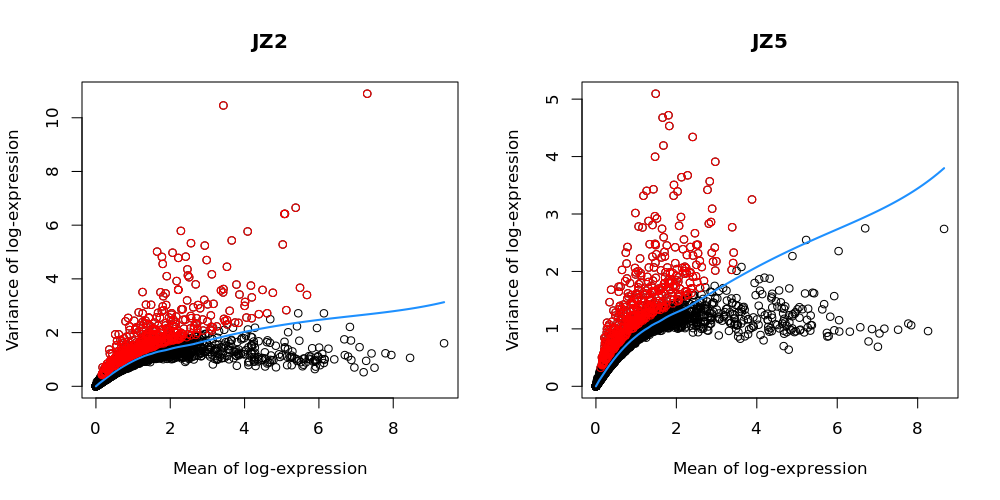

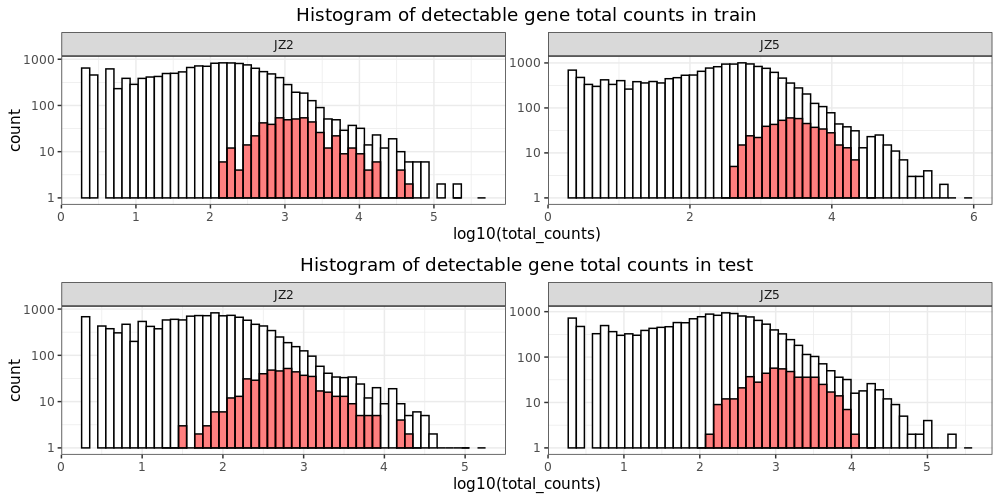

In [4]:
%%R -w 10 -h 5 --units in -r 100
names(sce_list) <- ids

op <- par(no.readonly = TRUE)
par(mfrow=c(1,2))
lapply(sce_list, function(sce){
  
  var_fit <- trendVar(sce[, sce$split == 'train'], assay.type="logcounts", use.spikes=FALSE)
  hvgs <- rownames(sce)[rowData(sce)$is_hvgs]
  plot(var_fit$mean, var_fit$var, xlab="Mean of log-expression",
       ylab="Variance of log-expression", main = sce$id[1])
  curve(var_fit$trend(x), col="dodgerblue", add=TRUE, lwd=2)
  points(var_fit$mean[hvgs], var_fit$var[hvgs], col = 'red')
  
})
par(op)

make_hist_plots <- function(sce_list, split = NULL){
    
    gene_total_counts <- lapply(sce_list, function(sce) {
        
        if(!is.null(split)) sce <- sce[, sce$split == split]
        
        df <- as.data.frame(rowSums(counts(sce))) %>% tibble::rownames_to_column('gene_symbol')
        colnames(df) <- c('gene_symbol', 'total_counts')
        df$id <- rep(sce$id[1], nrow(df))
        df$is_hvg <- rowData(sce)$is_hvgs
        return(df)
    })

    df <- Reduce(rbind, gene_total_counts)
  
    my_theme <- theme(plot.title = element_text(hjust = 0.5))
    p<- ggplot(df[df$total_counts > 1, ], aes(x = log10(total_counts))) + 
    geom_histogram(bins = 50, color="black", fill="white") +
    geom_histogram(df[df$is_hvg, ], mapping = aes(x = log10(total_counts)), 
                   bins = 50, color="black", fill="red", alpha = 0.5) +
    facet_wrap( ~ id, ncol=2, scales="free") + theme_bw() + 
    labs(title = paste('Histogram of detectable gene total counts in', split)) + my_theme + scale_y_log10()
    
    return(p)
}

p1 <- make_hist_plots(sce_list, split = 'train')
p2 <- make_hist_plots(sce_list, split = 'test')
plot_grid(p1, p2, nrow = 2)

As expected, genes in the top 500 HVGs (red dots) deviate the most from the fitted trends (blue curves) and have average to high abundance (red bars).The gene total counts distributions between trainset and testset are quite similar. Detectable genes are genes whose total counts are more than 1.

### Dimensionality reduction plots

In [23]:
def make_rd_plots(sce, method, argument_dict = {}):
    train_df, test_df, _ = utility.prepare_fastai_inputs(sce, assay = 'normalized', gene_filter = True)
    [print('{id} {split} 0:1 ratio = {ratio}'\
           .format(id = sce.obs['id'][0], split = x, ratio = round(y.label.value_counts()[0]/y.label.value_counts()[1], 2))) \
     for x, y in zip(['Train', 'Test'], [train_df, test_df])]
    def make_rd(rdm, df):
        # for visualization so ignore data leaking
        rd = rdm.fit_transform(df[df.columns.difference(['label'])])
        rd = utility.array_to_df(rd, colname_prefix = 'Dim')
        rd['label'] = df.reset_index()['label']
        return rd 
    # if PCA input data is centered but not scaled for each feature
    rdm = partial(method, **argument_dict)()
    rd_dict = {k: make_rd(rdm, v) for k, v in zip(['train', 'test'], [train_df, test_df])}
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    for i, (k, v) in enumerate(rd_dict.items()):
        scatter = ax[i].scatter(x = v.Dim1, y = v.Dim2, c=v.label)
        legend = ax[i].legend(*scatter.legend_elements(), loc="best", title="Classes") 
        ax[i].add_artist(legend)
        ax[i].set_title(k)
    fig.suptitle(sce.obs['id'][0])

JZ2 Train 0:1 ratio = 1.15
JZ2 Test 0:1 ratio = 1.14
JZ5 Train 0:1 ratio = 1.38
JZ5 Test 0:1 ratio = 1.38


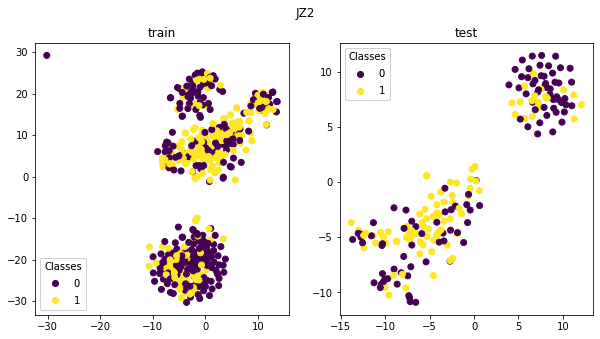

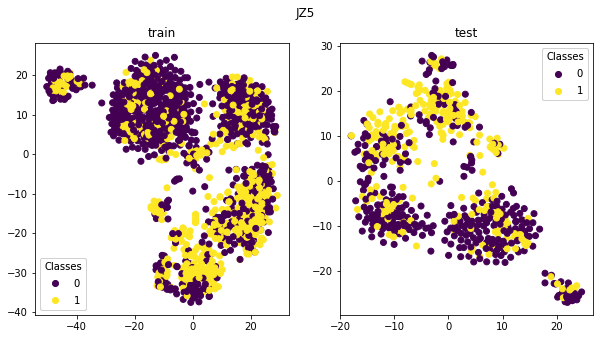

In [25]:
tmp = [make_rd_plots(sce, TSNE, {'n_jobs':10, 'random_state':0}) for sce in sce_list]

Classes ratios are quite balanced but positive cells and negative cells don't form separate clusters.   

# Baseline models

Top 500 HVGs are centered and scaled then further reduced to top 100 PCs before fitting each classifier (except for Random Forest):

- Logistic Regression (LR): use balanced class weights 
- Gaussian Naive Bayes (GNB): no class prior provided
- Ada Boost GNB (AdaGNB): weighted average of 50 GNBs 
- Linear Support Vector Classification (SVM): use balanced class weights
- Multi-layer Perceptron Classifier (MLP): hidden layers size (5, 16, 8), Adam optimimer with adaptive learning rate(keep learning rate at 0.001 and each time two consecutive epochs fail to decrease training loss by at least 0.0001, current learning rate is divided by 5), Relu activation function, batch size = min(200, n_cells) and L2 penalty with $\alpha = $ 0.0001
- Bags of MLPs (Bagging MLP): Bag of 50 MLPs, each with the structure outlined above, bootstrap cells (for each base classifier, sample `1.0 * X_train.shape[0]` cells with replacement from trainset), no feature bootstrapping
- Random Forest Classifier (RF): Bags of 500 trees, bootstrap cells (for each base classifier, sample `1.0 * X_train.shape[0]` cells with replacement from trainset), consider at most $\sqrt{500}$ features at each split or until at least one valid partition is found, quality of a split is measured with Gini impurity, nodes are expanded until all leaves are pure or until all leaves contain less than 2 cells

In [5]:
def build_bl_models(sce, cv_scoring, eval_scoring, seed):
    train_df, test_df, _ = utility.prepare_fastai_inputs(sce, assay = 'normalized', gene_filter = True)
    X_train, X_test, y_train, y_test = train_df[train_df.columns.difference(['label'])], \
    test_df[test_df.columns.difference(['label'])], train_df.label, test_df.label
    
    models = rputility.make_models(seed = seed)
    
    eid = sce.obs['id'][0]
    print(eid)
    cv_scores_df, eval_scores_df = rputility.build_models(models, X_train, X_test, y_train, y_test, 
                                 cv = 3, cv_random_state = seed, 
                                 cv_scoring = cv_scoring, eval_scoring = eval_scoring,
                                 eid = eid, verbose = False)
    return {'cv_scores_dfs': cv_scores_df, 'eval_scores_dfs': eval_scores_df, 'fitted_models':models} 

In [6]:
cv_scoring = {'accuracy': make_scorer(accuracy_score), 
              'f1': make_scorer(fbeta_score, beta = 1, average = 'weighted'),
              # estimators that have either a decision_function or predict_proba method for roc_auc
              # set needs_threshold = True if estimators only have decision_function method 
              'roc_auc': make_scorer(roc_auc_score, average = 'weighted', needs_threshold = True)}

eval_scoring = {'cfm': rputility.make_score(confusion_matrix, needs_threshold = False),
                'accuracy': rputility.make_score(accuracy_score, needs_threshold = False),
                'f1': rputility.make_score(fbeta_score, {'beta':1, 'average':'weighted'}, needs_threshold = False),
                'roc_auc': rputility.make_score(roc_auc_score, {'average':'weighted'}, needs_threshold = True)}

results = [build_bl_models(sce, cv_scoring, eval_scoring, seed = 0) for sce in sce_list]

JZ2



JZ5


In [7]:
cv_scores_df = pd.concat([r['cv_scores_dfs'] for r in results])
eval_scores_df = pd.concat([r['eval_scores_dfs'] for r in results])
eval_scores_df_r = eval_scores_df.loc[eval_scores_df['score_type'] != 'cfm']
eval_scores_df_r.loc[:, 'score'] = eval_scores_df_r['score'].astype('float64')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


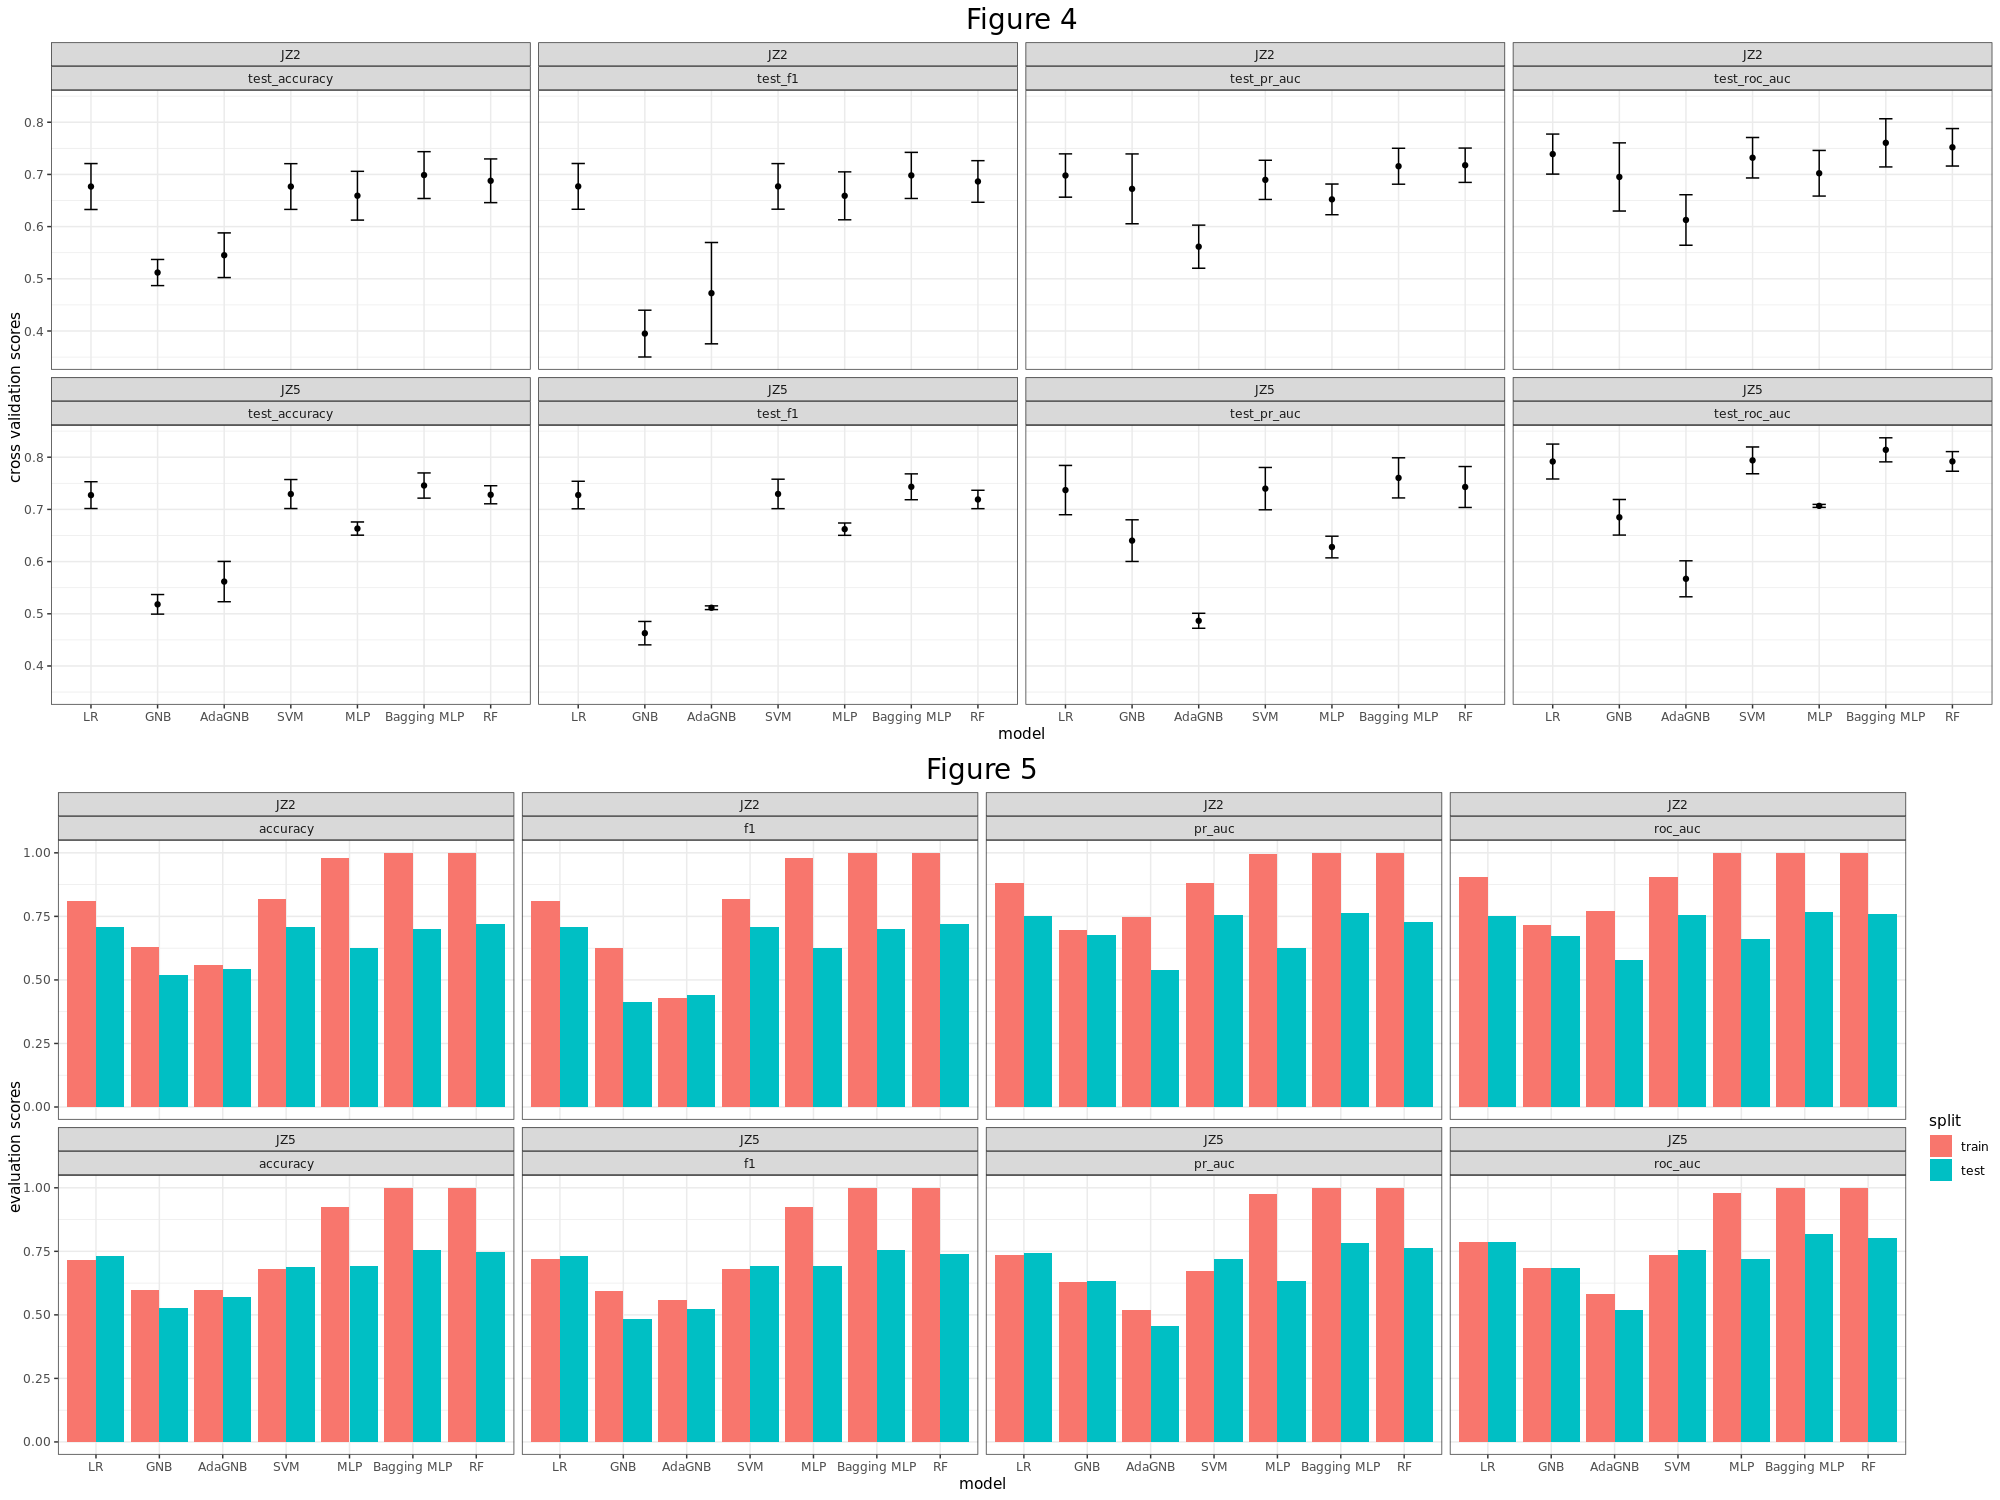

In [12]:
%%R -i cv_scores_df -i eval_scores_df_r -w 20 -h 15 --units in -r 100

my_theme <- theme(plot.title = element_text(size = 20, hjust = 0.5))

cv_scores_df$model <- factor(cv_scores_df$model, level = c(unique(cv_scores_df$model)))
p1 <- ggplot(cv_scores_df, aes(x=model, y=mean, group=score_type)) +
geom_point() + geom_errorbar(aes(ymin=mean-std, ymax=mean+std), width=.2, position=position_dodge(0.05)) +
facet_wrap(~ id + score_type, nrow = 2) + theme_bw() + labs(title = 'Figure 4',y = 'cross validation scores') + my_theme

eval_scores_df_r$model <- factor(eval_scores_df_r$model, level = c(unique(eval_scores_df_r$model)))
eval_scores_df_r$split <- factor(eval_scores_df_r$split, level = c(unique(eval_scores_df_r$split)))
p2 <- ggplot(eval_scores_df_r, aes(x=model, y=score, fill = split)) +
geom_bar(stat = 'identity', position="dodge") + 
facet_wrap(~ id + score_type, nrow = 2) + theme_bw() + labs(title = 'Figure 5', y = 'evaluation scores') + my_theme

plot_grid(p1, p2, ncol = 1)

3-folds cross-validation used to estimate the generlization errors of each baseline models as shown in Figure 4. Bagging MLP has the best performce in all cross validation metrics (accuracy, weighted F1, weighted Receiver Operating Characteristic (ROC) AUC and weighted Precision-Recall (PR) AUC and on both experiments. When evaluated on the test set, Bagging MLP also has best performce so we will use it as the baseline model. Notice that we didn't perform any hyper-parameter tuning with cross-validation since the goal is to find a decent baseline model. 

# Competing models 

In [10]:
def show_results(learner, y_test_labels, train_df, test_df):
    # Learner methods will modify learner object in place, so make a deepcopy first
    try:
        learner_clone = deepcopy(learner)
    except NotImplementedError:
        learner_clone = learner
    # collect metrics names before they get overwrite after calling class methods
    metrics_names = ['loss', *[i for i in learner_clone.recorder.names \
                               if i not in ['epoch', 'train_loss', 'valid_loss', 'time']]]
    # get the list of preds, y, losses from get_preds() for train, valid, test
    preds = {str(k).split('.')[1]: learner_clone.get_preds(with_loss=True, ds_type=k) \
             for k in [DatasetType.Train, DatasetType.Valid, DatasetType.Test]}
    # replace test dummy labels with the actual labels 
    preds['Test'][1] = torch.tensor(y_test_labels, dtype = torch.int64)
    # contruct ClassificationInterpretation object 
    interps = {k: ClassificationInterpretation(learner_clone, *preds[k]) for k in preds}
    confusion_matrixs = {k: interps[k].confusion_matrix() for k in interps}
    confusion_matrixs = {k: [i + '=' + str(j) for i, j in zip(['TN', 'FP', 'FN', 'TP'], v.flatten())] \
                         for k, v in confusion_matrixs.items()}
    # create dummy databunch, using test as validation because in fastai test is always unlabeled 
    all_data_df = pd.concat([train_df, test_df])
    test_idx =np.arange(train_df.shape[0], all_data_df.shape[0])
    dummy_db = TabularDataBunch.from_df(path = '.', df = all_data_df, dep_var = 'label', valid_idx = test_idx, 
                         procs = [Normalize], cont_names = train_df.columns.difference(['label']),
                         bs = all_data_df.shape[0] - len(test_idx))
    # collect metrics
    metrics = {k: learner_clone.validate(x) \
               for k, x in zip(list(preds.keys()), [learner_clone.data.train_dl, learner_clone.data.valid_dl, dummy_db.valid_dl])}
    named_metrics = {ok: {ik: round(float(iv), 2) for ik, iv in zip(metrics_names, ov)} for ok, ov in metrics.items()}
    results = {'cfm': confusion_matrixs, 'metrics': named_metrics}
    tmp = [print(k, v) for k, v in results['cfm'].items()]
    tmp = [print(k, v) for k, v in {ok: [ik + '=' + str(iv) for ik, iv in ov.items()] \
                                    for ok, ov in results['metrics'].items()}.items()]

class StoreActivations(HookCallback):
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True, 
                 bins:int=10, hmin:int=0, hmax:int=0):
        self.bins, self.hmin, self.hmax = bins, hmin, hmax
        modules = modules if modules and isinstance(modules, list) else flatten_model(learn.model)
        super().__init__(learn, modules, do_remove) # init HookCallback
        
    def on_train_begin(self, **kwargs): # customize .on_train_begin
        super().on_train_begin(**kwargs) # call .on_train_begin of HookCallback, which add hooks to layers
        self.hists = []
        self.shape_out={}
        
    def hook(self, m, i, o): # define what the hook does; module, input, output, run for each batch, both train and val 
        # collect layer info 
        if (m not in self.shape_out) and (isinstance(o,torch.Tensor)):
            outShape = o.shape
            self.shape_out[m]=outShape
        # o = activations from 1 layer for 1 batch (# activations = # activations in layer * # batches)
        return o # simply return the output (i.e., activations) of the module/layer, stored in self.hooks.stored
        
    def on_batch_end(self, train, **kwargs):
        if (train): # collect for train 
            # histogram of activations from a layer for all samples in a batch, torch.histc only works on CPU
            # construct a histogram if layer contains activations, otherwise return None 
            self.hists.append([l.cpu().histc(self.bins, self.hmin, self.hmax) \
                               if l is not None else None for l in self.hooks.stored]) 
    
    def splitAtFirstParenthesis(self, s):
        pos=len(s.split('(')[0])
        ret = s[:pos]
        return ret
    
    def plot_hist(self, cols=4, figsize=(10,10), axis_off = False):
        # element-wise list combination, layer->batch->histogram
        layer_hist = [l for l in zip(*self.hists)]  
        # None if layer has no activations, else stack batches together 
        layer_hist = [None if l[0] is None else torch.stack(l).t().float().log1p() for l in layer_hist]
        # remove layer with no histogram
        layer_hist = [l for l in layer_hist if l is not None]
        layerIds = listify(self.shape_out)
        rows = int(math.ceil(len(layer_hist)/cols))
        fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
        for ax, h, lid in zip(axes.flatten(), layer_hist, layerIds):
            # plot histogram 
            ax.imshow(h, origin='lower')
            ax.set_aspect('auto')
            # add zero horizontal line
            imgW=h.shape[1]
            imgH=h.shape[0]
            if (self.hmax-self.hmin):
                ratioH=-self.hmin/(self.hmax-self.hmin)
                zeroPosH = imgH*ratioH
                ax.plot([0,imgW],[zeroPosH,zeroPosH],'r') 
            # set-up axis display  
            if axis_off: ax.axis('off')
            ax.set_yticks([])
            ax.set_ylabel(str(self.hmin) + " : " + str(self.hmax))
            ax.set_xlim([0,imgW])
            ax.set_ylim([0,imgH])
            # add title
            title = self.splitAtFirstParenthesis(str(lid)) + '\nout: ' + str(list(self.shape_out[lid]))
            ax.set_title(title)
        plt.tight_layout()

def make_learner(data, layers, ps, use_bn, wd, metrics, silent = True, 
                 callback_fns = None, activation_fn = None, bins = 40, hmin = -5, hmax = 5): 
    learner = tabular_learner(data = data, layers = layers, ps = ps, use_bn = use_bn, wd = wd,
                          metrics = metrics,
                          callback_fns=callback_fns,
                          silent = silent) 
    if activation_fn:
        #replace nn.ReLU with other activation fn, 
        #tabular_learner doesn't have an argument to change default activation fn
        for i, j in enumerate(learner.model.layers):
            if isinstance(j, nn.ReLU):
                learner.model.layers[i] = activation_fn(inplace=True)
    
    #record_layers = [l for l in flatten_model(learner.model) if not isinstance(l, nn.ModuleList)]
    learner.callbacks += [ StoreActivations(learn = learner, modules=None, bins = bins, hmin = hmin, hmax = hmax) ]
    
    return learner

In [39]:
class StoreGradients(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.grads = []
    # after the gradients have been computed but before the optimizer is called
    def on_backward_end(self, iteration, **kwargs): 
        for n, p in self.learn.model.named_parameters():
            if(p.requires_grad) and ("weight" in n):
                self.grads.append({'iteration':iteration, 
                                   'layer_name':n,
                                   'mean_grad':p.grad.abs().mean().numpy(),
                                   'max_grad':p.grad.abs().max().numpy()})
    # adapt from https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7 and
    # https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
    def plot_grads(self, mode, rotation = 0, figsize = (15, 6)):
        df = pd.DataFrame(self.grads)
        fig, ax = plt.subplots(figsize=figsize)
        for label, d in df.groupby('iteration'):
            if mode == 'line':
                ax.plot(d.layer_name, d.mean_grad, color="b")
                ax.set_ylabel("average gradient")
            elif mode == 'bar':
                ax.bar(d.layer_name, d.max_grad, alpha=0.1, lw=1, color="c")
                ax.bar(d.layer_name, d.mean_grad, alpha=0.1, lw=1, color="b")
                ax.set_ylabel("average/max gradient")
            else:
                raise Exception('Unsupported plotting mode, pick "line" or "bar"')
            ax.tick_params(axis='x', rotation=rotation)
            ax.set_title("Gradient flow")

In [12]:
train_df, test_df, val_idx = rputility.prepare_fastai_inputs(sce_list[0], assay = 'normalized', gene_filter = True)
data = TabularDataBunch.from_df(path = '.', df = train_df, dep_var = 'label', valid_idx = val_idx, 
                         procs = [Normalize], cont_names = train_df.columns.difference(['label']),
                         test_df = test_df, bs = train_df.shape[0] - len(val_idx)) # train_df.shape[0] - len(val_idx)
print(['# cells in {data_type}_ds: {length}'.format(data_type = x, length = len(y)) \
 for x, y in zip(['train', 'val', 'test'], [data.train_ds, data.valid_ds, data.test_ds])])
print(['# batch in {data_type}_dl: {length}'.format(data_type = x, length = len(y)) \
 for x, y in zip(['train', 'val', 'test'], [data.train_dl.dl, data.valid_dl.dl, data.test_dl.dl])])

['# cells in train_ds: 318', '# cells in val_ds: 137', '# cells in test_ds: 193']
['# batch in train_dl: 1', '# batch in val_dl: 1', '# batch in test_dl: 1']


In [40]:
metrics = [accuracy, FBeta(beta = 1, average = 'weighted'), AUROC()]
callback_fns = [ActivationStats, StoreGradients ]#partial(EarlyStoppingCallback, monitor='valid_loss', mode = 'min', min_delta=1e-06, patience=5)
learner = make_learner(data = data, layers = [5, 16, 8], ps = 0.1, use_bn = True, wd = 0.2, silent = True,
                       metrics = metrics, callback_fns = callback_fns, bins = 40, hmin = -10, hmax = 10)

In [78]:
# adapt from https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
def weights_init_uniform_rule(l):
    classname = l.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = l.in_features
        y = 1.0/np.sqrt(n)
        l.weight.data.uniform_(-y, y)
        l.bias.data.fill_(0)

def init_weights(learner, func):
    learner.model.layers.apply(func)
    
init_weights(learner, weights_init_uniform_rule)

In [41]:
learner.fit(epochs = 20, lr = 1e-02, wd = 1e-04)

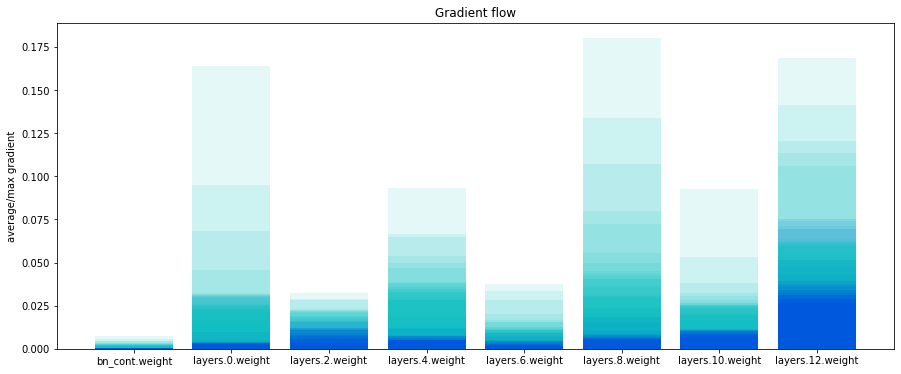

In [44]:
learner.store_gradients.plot_grads(mode = 'bar', rotation = 0, figsize = (15, 6)) 

In [19]:
df = pd.DataFrame(learner.store_gradients.grads)
df.head()

,iteration,layer_name,mean_grad,max_grad
0,0,bn_cont.weight,0.0012927384,0.0050099236
1,0,layers.0.weight,0.022567498,0.123017356
2,0,layers.2.weight,0.009608077,0.01995477
3,0,layers.4.weight,0.009804679,0.037705168
4,0,layers.6.weight,0.00506475,0.01439317


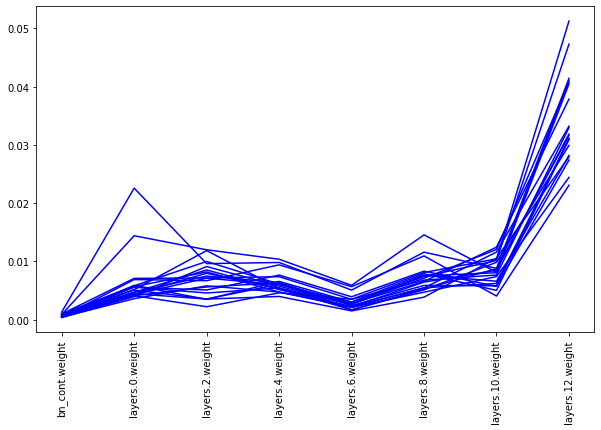

In [20]:
# adapt from https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7
fig, ax = plt.subplots(figsize=(10,6))
for label, d in df.groupby('iteration'):
    ax.plot(d.layer_name, d.mean_grad, color="b")
    ax.tick_params(axis='x', rotation=90)

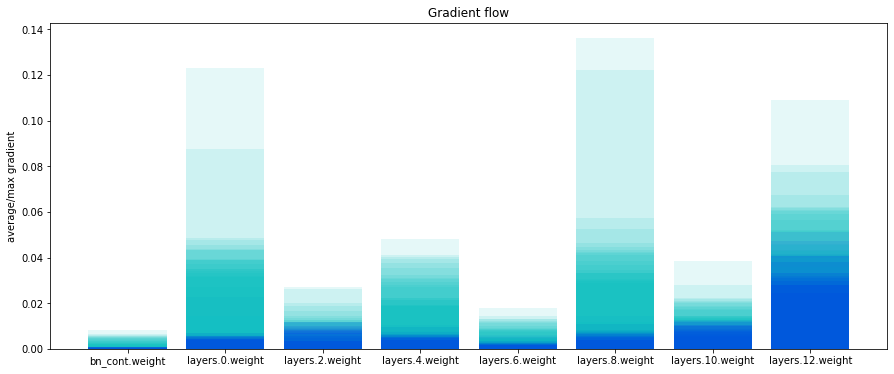

In [31]:
# adapt from https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
fig, ax = plt.subplots(figsize=(15,6))
for label, d in df.groupby('iteration'):
    ax.bar(d.layer_name, d.max_grad, alpha=0.1, lw=1, color="c")
    ax.bar(d.layer_name, d.mean_grad, alpha=0.1, lw=1, color="b")
    ax.set_ylabel("average/max gradient")
    ax.set_title("Gradient flow")

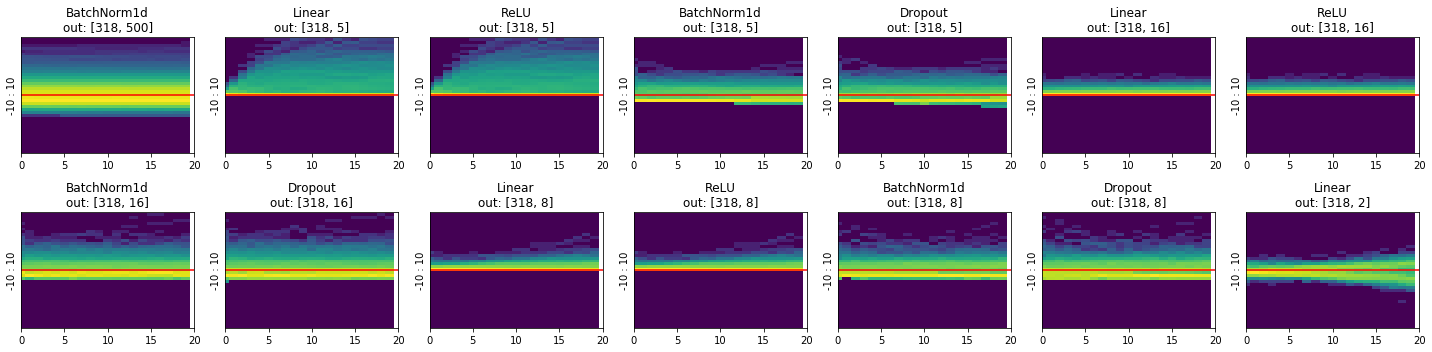

In [17]:
learner.store_activations.plot_hist(cols=7, figsize=(20, 5), axis_off = False)

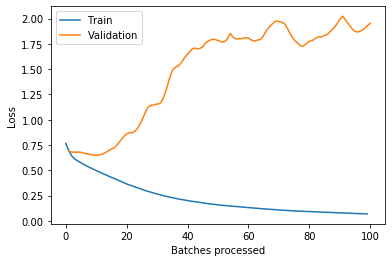

In [101]:
learner.recorder.plot_losses()

In [102]:
show_results(learner, test_df['label'], train_df, test_df)

Train ['TN=170', 'FP=0', 'FN=0', 'TP=148']
Valid ['TN=46', 'FP=27', 'FN=23', 'TP=41']
Test ['TN=75', 'FP=28', 'FN=31', 'TP=59']
Train ['loss=0.0', 'accuracy=1.0', 'auroc=1.0', 'f_beta=1.0', 'precision=1.0', 'recall=1.0']
Valid ['loss=1.95', 'accuracy=0.64', 'auroc=0.67', 'f_beta=0.65', 'precision=0.62', 'recall=0.64']
Test ['loss=1.71', 'accuracy=0.7', 'auroc=0.75', 'f_beta=0.73', 'precision=0.67', 'recall=0.7']


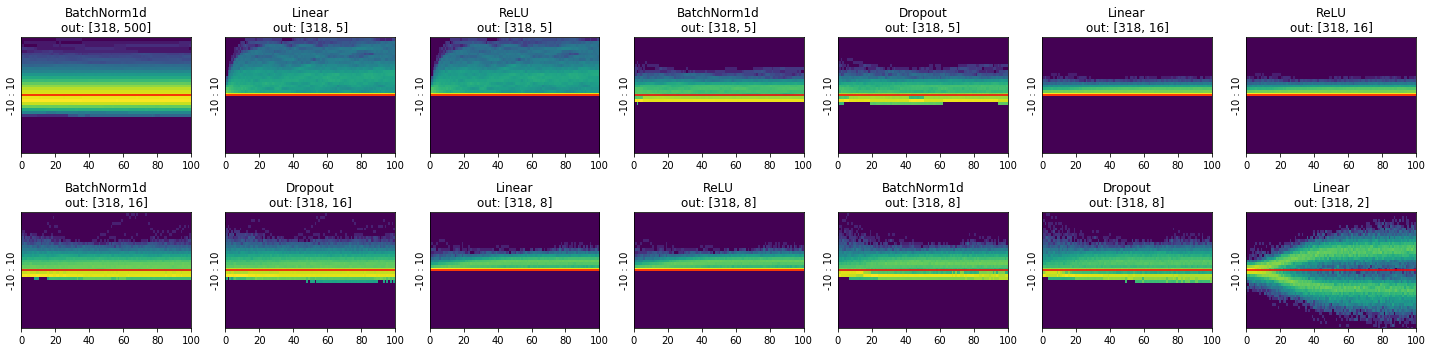

In [103]:
learner.store_activations.plot_hist(cols=7, figsize=(20, 5), axis_off = False)